In [15]:
from surgery_utils import surgery_preprocess, split, get_scores, plot_scores
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score,train_test_split,RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, f1_score, average_precision_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from hyperopt import Trials, fmin, tpe, anneal, space_eval, hp
from functools import partial

import numpy as np
import pandas as pd

In [22]:
surgery = surgery_preprocess(split=False)
ros = RandomOverSampler()
kf = StratifiedKFold()
surgery.columns

Index(['FVC', 'FEV1', 'Performance', 'Pain', 'Haemoptysis', 'Dyspnoea',
       'Cough', 'Weakness', 'Tumor_size', 'Type2_diabetes', 'Smoking', 'Age',
       'Risk1Yr', 'FEV1/FVC', 'FEV1_deficit', 'FVC_deficit',
       'FEV1/FVC_deficit', 'FEV1^2', 'FVC^2', 'Age*FVC', 'Age*FEV1',
       'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2', '_DGN2', '_DGN3', '_DGN4',
       '_DGN5'],
      dtype='object')

Our baseline model will be a logistic regression without any hyperparameter tuning, engineered features, or upsampling

In [73]:
lr_baseline = LogisticRegression()
engineered_feats = ['FEV1/FVC', 'FEV1_deficit', 'FVC_deficit',
       'FEV1/FVC_deficit', 'FEV1^2', 'FVC^2', 'Age*FVC', 'Age*FEV1',
       'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2']
scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']
baseline_scores = {}
for s in scores:
    baseline_scores[s] = np.zeros(30)

for i in range(30):
    X_train, X_test, y_train, y_test = split(surgery, drop_cols=engineered_feats)
    model_scores = get_scores(lr_baseline, X_train, X_test, 
                             y_train, y_test, scores, n=10)
    for s in scores:
        baseline_scores[s][i] = model_scores[s]
for s in scores:
    print(f'Mean {s}: {baseline_scores[s].mean()}')

Mean roc_auc_score: 0.6860458107293551
Mean recall_score: 0.019047619047619046
Mean accuracy_score: 0.8365591397849461
Mean average_precision_score: 0.15761356155365372


A Logistic Regression model after feature engineering, but without upsampling or tuning:

In [74]:
lr_engineering = LogisticRegression()
engineering_scores = {}
for s in scores:
    engineering_scores[s] = np.zeros(30)

for i in range(30):
    X_train, X_test, y_train, y_test = split(surgery)
    model_scores = get_scores(lr_engineering, X_train, X_test, 
                             y_train, y_test, scores,n=30)   
    for s in scores:
        engineering_scores[s][i] = model_scores[s]
for s in scores:
    print(f'Mean {s}: {engineering_scores[s].mean()}')

Mean roc_auc_score: 0.6633514165159737
Mean recall_score: 0.04047619047619047
Mean accuracy_score: 0.8379928315412185
Mean average_precision_score: 0.16289682539682535


We actually see a drop in AUC, indicated that our engineered features are overfitting. We therefore drop some of them:

In [88]:
to_drop = {'set_1': ['FVC*FEV1','FVC^2*FEV1','FEV1*FVC^2'],
           'set_2': ['FVC_deficit','FEV1_deficit','FEV1/FVC_deficit'],
           'set_3': ['FVC*FEV1','FVC^2*FEV1','FEV1*FVC^2','FVC_deficit','FEV1_deficit',
            'FEV1/FVC_deficit'],
           'set_4': ['FVC*FEV1','FVC^2','FEV1^2'],
           'set_5': ['FVC*FEV1','FVC^2','FEV1^2','FVC*FEV1','FVC^2*FEV1','FEV1*FVC^2']}
selection_results = {}

for k in to_drop.keys():
    lr = LogisticRegression(C=200)
    engineering_scores = {}
    for s in scores:
        engineering_scores[s] = np.zeros(20)

    for i in range(20):
        X_train, X_test, y_train, y_test = split(surgery)
        model_scores = get_scores(lr_engineering, X_train, X_test, 
                                 y_train, y_test, scores,n=30)   
        for s in scores:
            engineering_scores[s][i] = model_scores[s]
    selection_results[k] = engineering_scores

In [89]:
for k in selection_results.keys():
    print(f'{k} mean scores:')
    for s in scores:
        print(f'{s}: {selection_results[k][s].mean()}')
    print('')

set_1 mean scores:
roc_auc_score: 0.6756329113924051
recall_score: 0.03571428571428571
accuracy_score: 0.8306451612903224
average_precision_score: 0.15894530392802275

set_2 mean scores:
roc_auc_score: 0.6897377938517179
recall_score: 0.02857142857142857
accuracy_score: 0.838709677419355
average_precision_score: 0.16290322580645153

set_3 mean scores:
roc_auc_score: 0.6842676311030742
recall_score: 0.024999999999999994
accuracy_score: 0.836021505376344
average_precision_score: 0.15808371735791082

set_4 mean scores:
roc_auc_score: 0.6759041591320073
recall_score: 0.021428571428571425
accuracy_score: 0.8370967741935484
average_precision_score: 0.1561808755760368

set_5 mean scores:
roc_auc_score: 0.6594484629294756
recall_score: 0.02857142857142857
accuracy_score: 0.835483870967742
average_precision_score: 0.16183179723502297



Prior analyses showed that the results of our models are heavily dependent on the intial train/test split. We will therefore run multiple trials with this split as the start point and average the results.

In [20]:
def build_model(model, params, obj, scores, data, k=8, n=10, evals=70, scoring='roc_auc',
                drop=[], return_idx=False, **model_args):
    scores_dict={}
    param_list=[]
    if return_idx:
        idx_list = []
    for s in scores:
        scores_dict[s] = np.zeros(k)
        
    for i in range(k):
        X_train, X_test, y_train, y_test = split(data, drop_cols=drop)
        mod = model(**model_args)
        pipe = Pipeline([('upsample',ros),('model',mod)])
        trials = Trials()
        # Partial make its own callable function. When you call partial() you supply
        # a function with n args and supply k of them. Then, when you call the function
        # that partial creates, you supply the remaining n-k. These n-k serve as the
        # FIRST arguments to the function of which you made a partial
        fmin_func = partial(obj, pipe=pipe, train_X=X_train, train_y=y_train,
                            scoring=scoring)
        best = fmin(fn=fmin_func, 
                    space=params, algo=anneal.suggest, max_evals=evals,
                    trials=trials)
        best_params = space_eval(params,best)
        
        pipe.fit(X_train,y_train)
        pipe.set_params(**best_params)
        model_scores = get_scores(pipe, X_train, X_test, y_train, y_test,
                                  scores, n=n)
        for s in scores:
            scores_dict[s][i] = model_scores[s]
        param_list.append(best_params)
        if return_idx:
            idx_list.append(X_train.index)
        
    if return_idx:
        return scores_dict, param_list, idx_list
    return scores_dict, param_list

In [21]:
def lr_objective(params, pipe, train_X, train_y, scoring='roc_auc'):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring)
    return 1-score.mean()

scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']

lr_space = {'model__C': hp.uniform('model__C', 0,500)}
lr_args = {'max_iter': 2000,'C': 1.0000001}

lr_scores, lr_params, lr_idx = build_model(LogisticRegression, lr_space,
                                                         lr_objective, scores, surgery,
                                                         k=2,n=3,evals=30,,
                                                         return_idx=True, **lr_args)

Index(['FVC', 'FEV1', 'Performance', 'Pain', 'Haemoptysis', 'Dyspnoea',
       'Cough', 'Weakness', 'Tumor_size', 'Type2_diabetes', 'Smoking', 'Age',
       'FEV1/FVC', 'FEV1_deficit', 'FVC_deficit', 'FEV1/FVC_deficit', 'FVC^2',
       'Age*FVC', 'Age*FEV1', 'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2', '_DGN2',
       '_DGN3', '_DGN4', '_DGN5'],
      dtype='object')
 40%|███████████████████▌                             | 8/20 [00:06<00:10,  1.14trial/s, best loss: 0.3616161616161616]


KeyboardInterrupt: 

In [ ]:
def sv_objective(params, pipe, train_X, train_y, scoring='roc_auc'):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring)
    return 1-score.mean()

scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']

sv_space = {'model__C': hp.uniform('model__C', 0,500)}
sv_args = {'kernel': 'linear', 'probability': True}

sv_scores, sv_params, sv_idx = build_model(SVC, sv_space,
                                           sv_objective, scores, surgery,
                                           k=8,n=8,evals=40,
                                           return_idx=True, **sv_args)

In [18]:
import lightgbm as lgb

def lg_objective(params, pipe, train_X, train_y, scoring):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring).mean()
    return 1-score

lg_space = {'model__n_estimators': hp.choice('model__n_estimators', range(20,80)),
             'model__learning_rate': hp.uniform('model__learning_rate',0.001,0.35),
             'model__max_depth': hp.choice('model__max_depth', range(3,9)),
             'model__bagging_fraction ': hp.uniform('model__subsample', 0.7, 1.0),
             'model__lambda_l2': hp.uniform('model__lambda_l2', 0.1,21.0),
             'model__num_leaves': hp.choice('model__num_leaves',range(5,50)),
             'model__feature_fraction': hp.uniform('model__feature_fraction',0.6,1.0)}

cat_feats = list(range(2,11))+list(range(23,27))

lg_args = {'metric': 'binary_logloss', 'categorical_features': cat_feats,
           'early_stopping_rounds': 4}
scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']


lg_scores, lg_params = build_model(LGBMClassifier, lg_space, lg_objective,
                                   scores, k=8, n=8, evals=70 scoring='roc_auc', 
                                   **lg_args)

[{'model__C': 360.2255510012966}, {'model__C': 117.6098890211668}]

In [ ]:
def rf_objective(params, pipe, train_X, train_y, scoring='roc_auc'):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring).mean()
    return 1-score

rf_space = {'model__n_estimators': hp.choice('model__n_estimators', range(70,300)),
             'model__min_samples_leaf': hp.choice('model__min_samples_leaf',range(1,21)),
             'model__min_samples_split': hp.choice('model__min_samples_split',range(2,21)),
             'model__max_features': hp.uniform('model__max_features', 0.5, 0.9),
             'model__max_depth': hp.choice('model__max_depth', range(3,26))}

scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']


rf_scores, rf_params = build_model(RandomForestClassifier, rf_space, rf_objective,
                                   scores, k=8, n=8, evals=70, scoring='accuracy')

## Model explainability

For this use case, the black box nature of machine learning models limits their practicality in informing decision-making. A doctor may now that a patient is at risk, but they also need to know *why* in order to prepare a treatment plan. Feature importance, being a global metric, does not suffice for this. We need to understand local importance; thus, model explainability through SHAP and LIME.

### SHAP

In [97]:
# Code will for now be for a logistic regression. We'll update it with the best model later
# Use params and X_train of an average trial
import shap
lr_pipe = Pipeline([('upsample',ros),('model',LogisticRegression(max_iter=2000))])
lr_pipe.set_params(**lr_params[1])
X_train, X_test, y_train, y_test = split(surgery, idx=lr_idx[1])
lr_pipe.fit(X_train, y_train)

lr_explainer = shap.KernelExplainer(lr_pipe.predict_proba, X_test)
lr_shapvals = lr_explainer.shap_values(X_test)

shap.initjs()

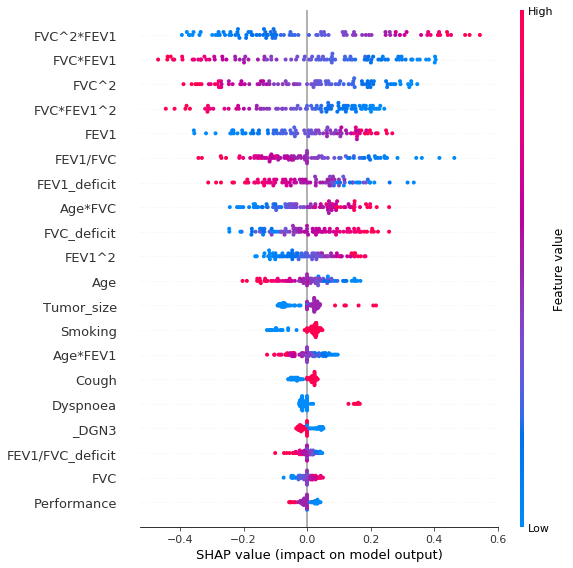

In [98]:
# The summary plot shows the SHAP value for each feature and for each
# instance, colored by magnitude of the feature
shap.summary_plot(lr_shapvals[1], X_test)

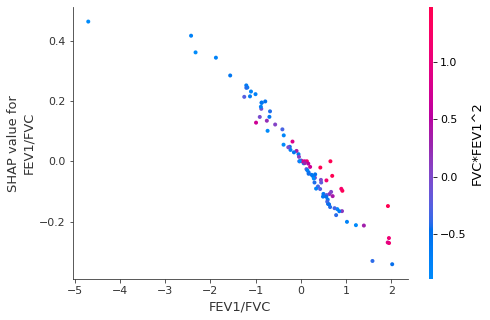

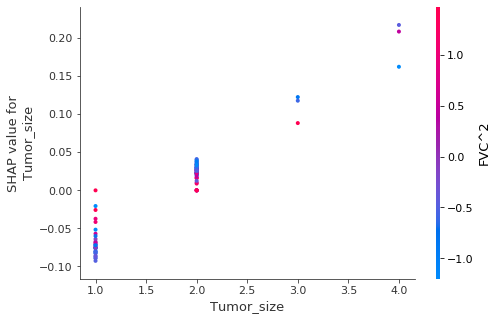

In [101]:
# The dependence plot shows how a single feature's SHAP value
# depends on its magnitude. It is colored by whichever other
# feature the chosen one interacts most with

shap.dependence_plot('FEV1/FVC',lr_shapvals[1], X_test)
shap.dependence_plot('Tumor_size',lr_shapvals[1], X_test)

The force plot is our local explainability. Red wedges indicatethat that feature made our prediction more likely to be positive. Blue, the opposite. Wedge width corresponds to that feature's Shapley value. The middle value (bold black text) is what the model predicts; the model then transforms that prediction into a \[0,1\] probability space. Here, if that value is above 0.42660686, the model predicts a positive.

In [102]:
lr_pipe.predict(X_test)

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0], dtype=int64)

In [108]:
lr_explainer.expected_value

array([0.57339314, 0.42660686])

In [105]:
shap_values_0 = lr_explainer.shap_values(X_test.iloc[0,:], nsamples=1000)
shap.force_plot(lr_explainer.expected_value[1], shap_values_2[1], X_test.iloc[0,:])

In [107]:
shap_values_1 = lr_explainer.shap_values(X_test.iloc[1,:], nsamples=1000)
shap.force_plot(lr_explainer.expected_value[1], shap_values_1[1], X_test.iloc[1,:])

Note how the most importance feature for the negative example was FVC^2, but the most important for the positive example was FVC\*FEV1. This shows how local feature importance can be different from global feature importance.

Finally, the global force plot. Each point on the x-axis is essentially the above plot, but flipped vertical

In [109]:
shap.force_plot(lr_explainer.expected_value[1], lr_shapvals[1], feature_names=X_test.columns)

### LIME